In [65]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import GridSearchCV


In [2]:
# Ingesting the csv dataset
df = pd.read_csv('https://github.com/nataliea30/DiabetesML/blob/34862282fc8283b4ff686564763586c3a63bdcdd/diabetes_prediction_dataset.csv?raw=true')


In [3]:
# Printing the DataFrame head and information
print(df.head())
df.info()

   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age               

In [4]:
# Dropping duplicates
df.drop_duplicates(inplace=True)

# Counting the number of distinct values in each column
num_distinct_values = df.nunique()
print(num_distinct_values)

# Checking null values
print(df.isnull().sum())

# Removing the 'Other' category from the 'gender' column
df = df[df['gender'] != 'Other']

gender                    3
age                     102
hypertension              2
heart_disease             2
smoking_history           6
bmi                    4247
HbA1c_level              18
blood_glucose_level      18
diabetes                  2
dtype: int64
gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


In [5]:
# Define a function to map the existing categories to new ones in order to reduce to 3 main categories of smoking
def recategorize_smoking(smoking_status):
    if smoking_status in ['never', 'No Info']:
        return 'non-smoker'
    elif smoking_status == 'current':
        return 'current'
    elif smoking_status in ['ever', 'former', 'not current']:
        return 'past_smoker'

# Apply the function to the 'smoking_history' column
df.loc[:, 'smoking_history'] = df['smoking_history'].apply(recategorize_smoking)

# Check the new value counts
print(df['smoking_history'].value_counts())


smoking_history
non-smoker     67276
past_smoker    19655
current         9197
Name: count, dtype: int64


In [85]:
data = df.copy()

In [86]:
def perform_one_hot_encoding(df, column_name):
    # Perform one-hot encoding on the specified column
    dummies = pd.get_dummies(df[column_name], prefix=column_name)

    # Drop the original column and append the new dummy columns to the dataframe
    df = pd.concat([df.drop(column_name, axis=1), dummies], axis=1)

    return df

# Perform one-hot encoding on the gender variable
data = perform_one_hot_encoding(data, 'gender')

# Perform one-hot encoding on the smoking history variable
data = perform_one_hot_encoding(data, 'smoking_history')

In [80]:
print(data.head())

     bmi  HbA1c_level  blood_glucose_level  diabetes  smoking_history_current  \
0  25.19          6.6                  140         0                    False   
1  27.32          6.6                   80         0                    False   
2  27.32          5.7                  158         0                    False   
3  23.45          5.0                  155         0                     True   
4  20.14          4.8                  155         0                     True   

   smoking_history_non-smoker  smoking_history_past_smoker  
0                        True                        False  
1                        True                        False  
2                        True                        False  
3                       False                        False  
4                       False                        False  


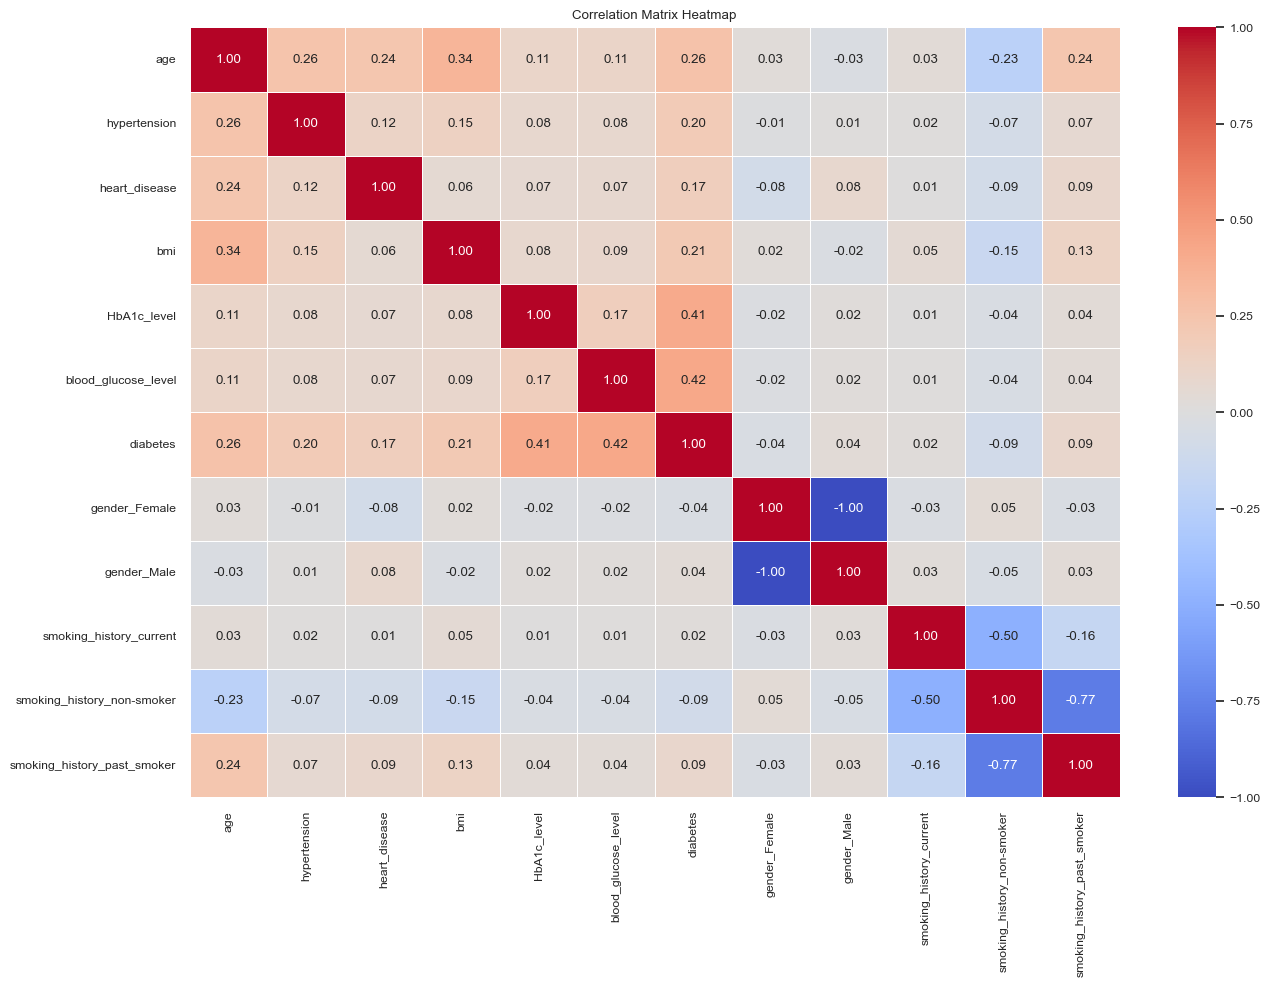

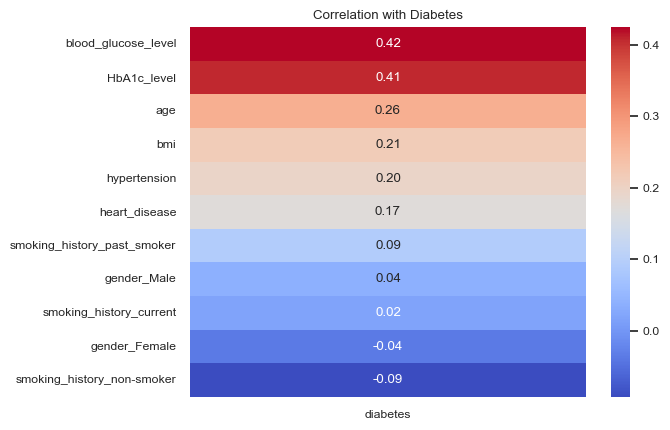

In [53]:
# Compute the correlation matrix
correlation_matrix = data.corr()
#Graph I.
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()


#Graph II
# Create a heatmap of the correlations with the target column
corr = data.corr()
target_corr = corr['diabetes'].drop('diabetes')

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)

sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Diabetes')
plt.show()

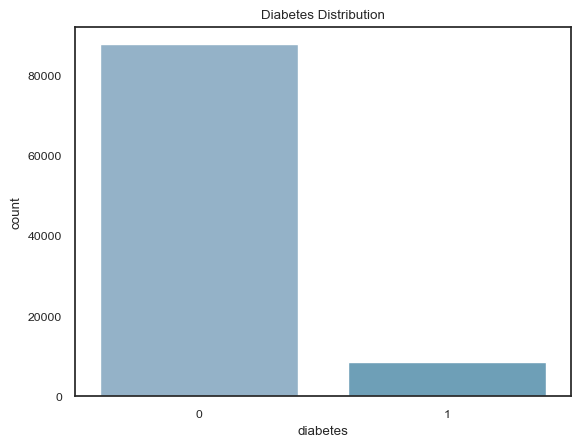

In [10]:
#data is unbalanced, 91% negative to 9% positive
sns.countplot(x='diabetes', data=df)
plt.title('Diabetes Distribution')
plt.show()

In [88]:
data = data.drop('HbA1c_level', axis=1)
data = data.drop('blood_glucose_level', axis=1)


In [91]:

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age','bmi']),
        ('cat', OneHotEncoder(), ['gender_Female', 'gender_Male', 'smoking_history_current', 'smoking_history_non-smoker', 'smoking_history_past_smoker'])
    ])


# Create resampling objects
over = SMOTE()
under = RandomUnderSampler()




# Split data into features and target variable
X = data.drop('diabetes', axis=1)
y = data['diabetes']



# Preprocess the data, oversample, and undersample
X_preprocessed = preprocessor.fit_transform(X)

X_resampled, y_resampled = over.fit_resample(X_preprocessed, y)
X_resampled, y_resampled = under.fit_resample(X_resampled, y_resampled)

# Split resampled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Create and train the classifier
clf = RandomForestClassifier(class_weight='balanced', max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100)
clf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=4, min_samples_split=10)

Model Accuracy:  0.7770044781653783
              precision    recall  f1-score   support

           0       0.82      0.71      0.76     17530
           1       0.74      0.85      0.79     17529

    accuracy                           0.78     35059
   macro avg       0.78      0.78      0.78     35059
weighted avg       0.78      0.78      0.78     35059



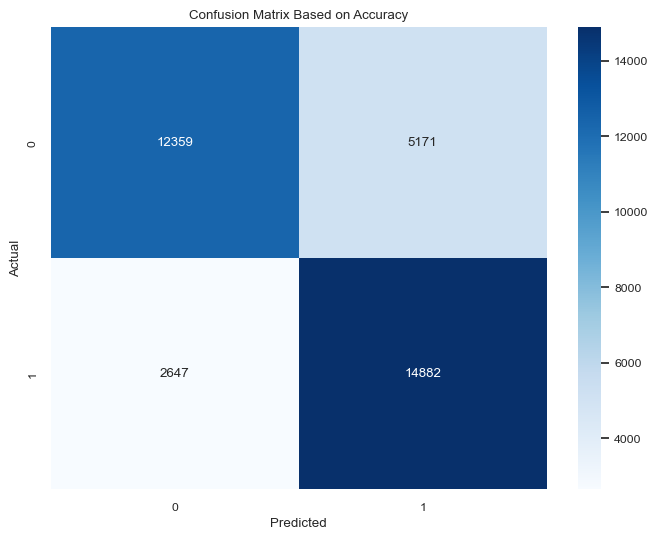

[-8.36773355e-01 -2.14288114e-04  1.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  0.00000000e+00  1.00000000e+00
  1.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]


In [92]:
# Predict on the test set using the trained classifier
y_pred_resampled = clf.predict(X_test)

# Evaluate the model
print("Model Accuracy: ", accuracy_score(y_test, y_pred_resampled))
print(classification_report(y_test, y_pred_resampled))

# Plotting the confusion matrix
cm = confusion_matrix(y_test, y_pred_resampled)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Based on Accuracy')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(X_train[0])

The following is another Random Decision Classification Model optimized based on recall.


In [13]:
# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']),
        ('cat', OneHotEncoder(), ['gender_Female', 'gender_Male', 'smoking_history_current', 'smoking_history_non-smoker', 'smoking_history_past_smoker'])
    ])

# Create resampling objects
over = SMOTE()
under = RandomUnderSampler()

# Split data into features and target variable
X = data.drop('diabetes', axis=1)
y = data['diabetes']

# Preprocess the data, oversample, and undersample
X_preprocessed = preprocessor.fit_transform(X)

X_resampled, y_resampled = over.fit_resample(X_preprocessed, y)
X_resampled, y_resampled = under.fit_resample(X_resampled, y_resampled)

# Split resampled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Create and train the classifier
clf = RandomForestClassifier(class_weight='balanced', max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100)
clf.fit(X_train, y_train)



RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=4, min_samples_split=10)

In [40]:
import _pickle as cPickle

with open('Diabetes.model', 'wb') as f:
    cPickle.dump(clf, f)

Model Recall Score:  0.9385019111187175
              precision    recall  f1-score   support

           0       0.94      0.89      0.91     17530
           1       0.90      0.94      0.92     17529

    accuracy                           0.92     35059
   macro avg       0.92      0.92      0.92     35059
weighted avg       0.92      0.92      0.92     35059



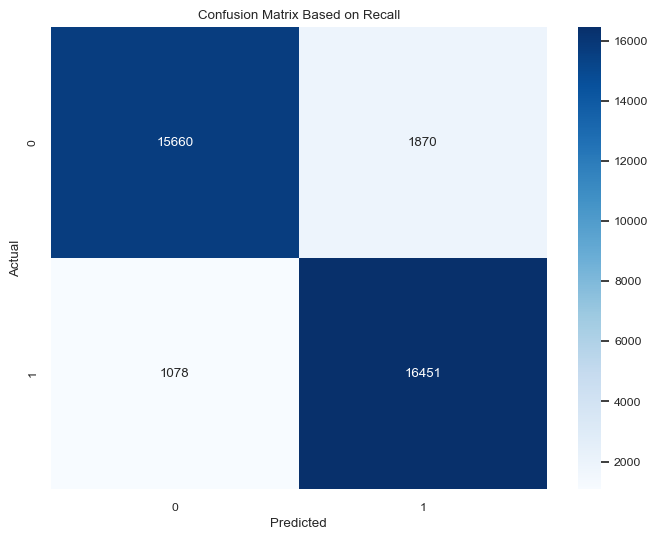

In [14]:
# Predict on the test set using the trained classifier
y_pred_resampled = clf.predict(X_test)

# Evaluate the model
print("Model Recall Score: ", recall_score(y_test, y_pred_resampled))
print(classification_report(y_test, y_pred_resampled))

# Plotting the confusion matrix
cm = confusion_matrix(y_test, y_pred_resampled)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Based on Recall')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

[[ 1.70070880e+00 -3.14941043e-01  9.94547463e-01 ...  1.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [ 5.43260798e-01 -2.14288114e-04  9.94547463e-01 ...  1.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [-6.14187201e-01 -2.14288114e-04  1.55949002e-01 ...  1.00000000e+00
   1.00000000e+00  0.00000000e+00]
 ...
 [-7.74912716e-01 -2.06540438e-01  2.76613029e+00 ...  1.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [ 1.70070880e+00  1.35714063e-02  3.23081003e+00 ...  1.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [ 1.03963813e+00 -4.39966514e-03  9.80549462e-01 ...  1.00000000e+00
   1.00000000e+00  0.00000000e+00]]


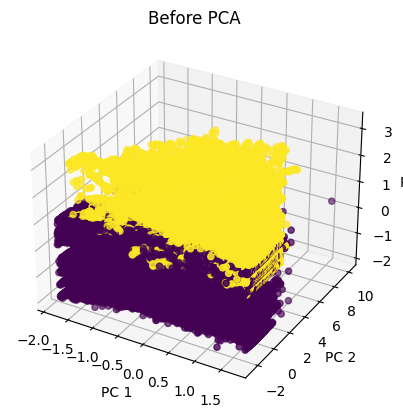

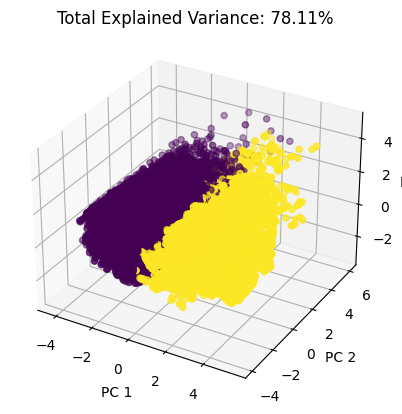

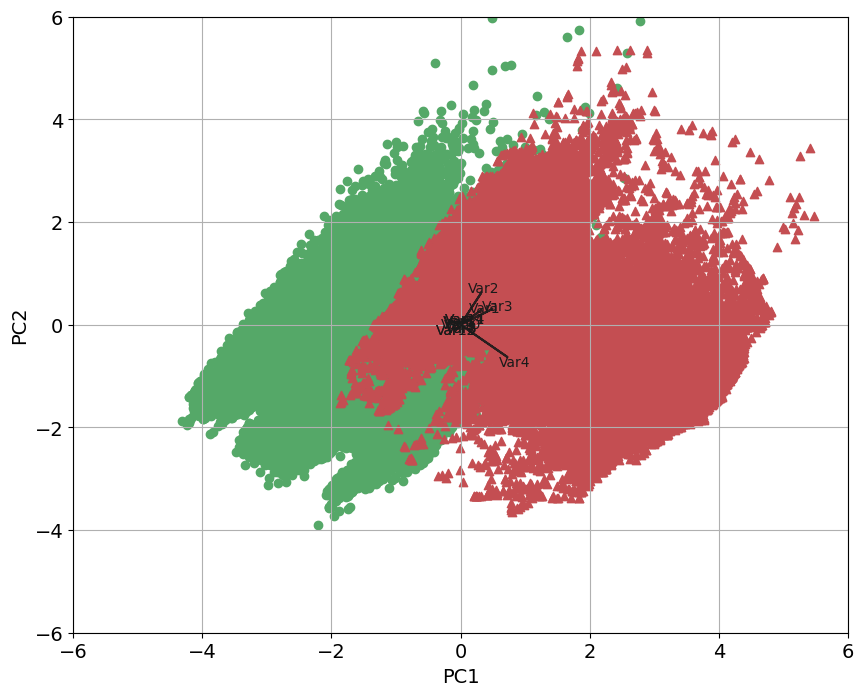

In [39]:

from sklearn.decomposition import PCA


X2 = X_resampled

print(X2)

# Get the principal components
pc1 = X2[:, 0]
pc2 = X2[:, 1]
pc3 = X2[:, 2]

# Create a scatter plot in 3D
fig = plt.figure()
ab = fig.add_subplot(111, projection='3d')
ab.scatter(pc1, pc2, pc3, c=y_resampled)

# Set the axis labels
ab.set_xlabel('PC 1')
ab.set_ylabel('PC 2')
ab.set_zlabel('PC 3')

ab.set_title(f'Before PCA')

plt.show()

# Perform PCA on the feature data
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X2)

# Get the principal components
pc1 = X_pca[:, 0]
pc2 = X_pca[:, 1]
pc3 = X_pca[:, 2]

# Create a scatter plot in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pc1, pc2, pc3, c=y_resampled)

# Set the axis labels
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

# Set the title
total_var = sum(pca.explained_variance_ratio_) * 100
ax.set_title(f'Total Explained Variance: {total_var:.2f}%')

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault) # reset ggplot style
# Call the biplot function for only the first 2 PCs
biplot(X_pca[:,0:14], np.transpose(pca.components_[0:14, :]), y_resampled)

# Show the plot
plt.show()

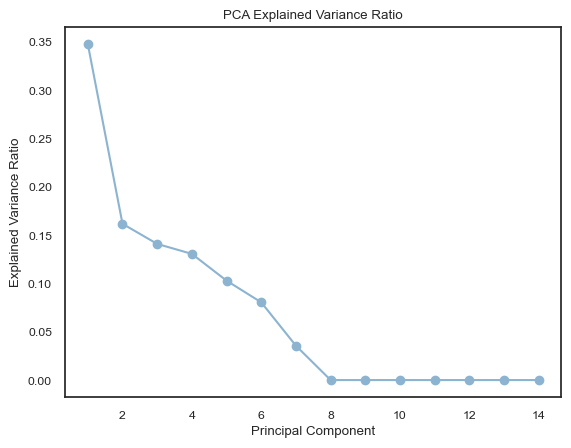

In [25]:
# Zero-center the scaled feature data
X_zero_centered = X2 - X2.mean(axis=0)

# Perform PCA on the zero-centered feature data
pca = PCA()
X_pca = pca.fit_transform(X_zero_centered)

# Calculate the explained variance ratio for each principal component
explained_variances = pca.explained_variance_ratio_

# Create a line plot for the explained variance ratio
plt.plot(range(1, len(explained_variances) + 1), explained_variances, marker='o')

# Add labels and title
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance Ratio')

# Display the plot
plt.show()

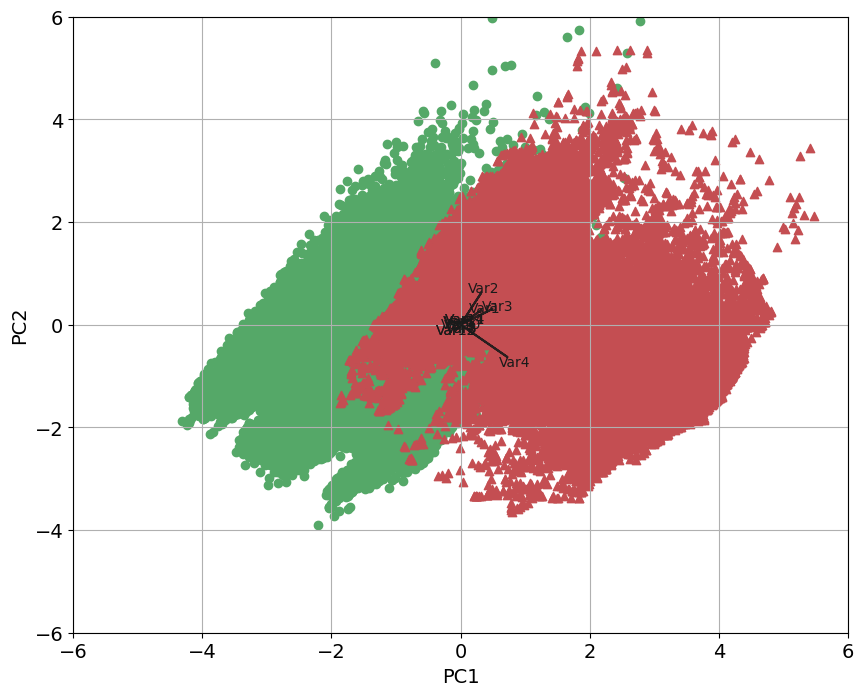

In [30]:
def biplot(score, coeff , y):
    '''
    Author: Serafeim Loukas, serafeim.loukas@epfl.ch
    Inputs:
       score: the projected data
       coeff: the eigenvectors (PCs)
       y: the class labels
   '''
    xs = score[:,0] # projection on PC1
    ys = score[:,1] # projection on PC2
    n = coeff.shape[0] # number of variables
    plt.figure(figsize=(10,8), dpi=100)
    classes = np.unique(y)
    colors = ['g','r','y']
    markers=['o','^','x']
    for s,l in enumerate(classes):
        plt.scatter(xs[y==l],ys[y==l], c = colors[s], marker=markers[s]) # color based on group
    for i in range(n):
        #plot as arrows the variable scores (each variable has a score for PC1 and one for PC2)
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'k', alpha = 0.9,linestyle = '-',linewidth = 1.5, overhang=0.2)
        plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'k', ha = 'center', va = 'center',fontsize=10)

    plt.xlabel("PC{}".format(1), size=14)
    plt.ylabel("PC{}".format(2), size=14)
    limx= int(xs.max()) + 1
    limy= int(ys.max()) + 1
    plt.xlim([-limx,limx])
    plt.ylim([-limy,limy])
    plt.grid()
    plt.tick_params(axis='both', which='both', labelsize=14)
    
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault) # reset ggplot style
# Call the biplot function for only the first 2 PCs
biplot(X_pca[:,0:14], np.transpose(pca.components_[0:14, :]), y_resampled)
plt.show()

In [38]:
print(abs( pca.components_ ))


[[3.22202742e-01 3.17873996e-01 4.98285644e-01 7.28418917e-01
  1.83127827e-02 1.83127827e-02 1.83127827e-02 1.83127827e-02
  7.81137859e-03 7.81137859e-03 6.45982132e-02 6.45982132e-02
  5.67868346e-02 5.67868346e-02]
 [2.86561191e-01 6.16083349e-01 3.09902604e-01 6.31512584e-01
  5.56253960e-02 5.56253960e-02 5.56253960e-02 5.56253960e-02
  4.62816855e-03 4.62816855e-03 9.03981703e-02 9.03981703e-02
  8.57700017e-02 8.57700017e-02]
 [7.87101049e-03 4.55550719e-01 5.86507513e-01 2.44634979e-01
  3.08572017e-01 3.08572017e-01 3.08572017e-01 3.08572017e-01
  9.58547371e-03 9.58547371e-03 4.78968293e-02 4.78968293e-02
  3.83113556e-02 3.83113556e-02]
 [1.19402448e-01 3.21061094e-01 5.18046949e-01 7.33957603e-02
  3.57884222e-01 3.57884222e-01 3.57884222e-01 3.57884222e-01
  2.67437213e-02 2.67437213e-02 1.67021709e-01 1.67021709e-01
  1.40277988e-01 1.40277988e-01]
 [5.14074451e-01 4.37760946e-01 1.48813353e-01 3.17738672e-02
  1.40879946e-01 1.40879946e-01 1.40879946e-01 1.40879946e-01


In [74]:
testData = np.array([[0.24912661,-0.20087521 ,0,0,1,1,1,0]])

clf.predict(testData)



array([0])